<a href="https://colab.research.google.com/github/CS418/group-project-jelabi/blob/main/418_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progress Report- Team Jalebi

## Project introduction:
The data we are analyzing is publicly accessible and located at https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp.
It can be quickly accessed as a CSV file or through an API
Depending on the year, each dataset contains roughly between 250,000-300,000 rows of reported crimes
Each row contains various pieces of information about every reported crime, including location, timestamp, type, etc. 
We plan to answer few of the below questions:
1. Which time of the day is safe?
2. Which day of the week is most prone to crimes?
3. What are the most common crimes?

## Any changes:
The scope has not changed since the check-in proposal slides.
- With crime on the rise in the city, it’s important to understand for students and all residents alike where extra precautions must be taken when traveling, as well as when it should be done.

In [2]:
!pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import scipy as sc
import math
import io
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sns

import pandas as pd
!pip install sodapy
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 200000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9hwr-2zxp", limit=200000)

# Convert to pandas DataFrame
dfOriginal = pd.DataFrame.from_records(results)
dfOriginal.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,...,ward,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id
0,2022-10-27T23:59:00.000,"{'latitude': '42.021675231', 'human_address': ...",024,077XX N MARSHFIELD AVE,1951183,42.021675231,DOMESTIC BATTERY SIMPLE,APARTMENT,2022-11-03T16:47:01.000,1,...,49,JF452232,2022,True,08B,-87.671894136,2422,BATTERY,False,12875321
1,2022-10-27T23:53:00.000,"{'latitude': '41.902923197', 'human_address': ...",012,028XX W DIVISION ST,1907857,41.902923197,RETAIL THEFT,GAS STATION,2022-11-03T16:47:01.000,24,...,26,JF452224,2022,False,06,-87.697288509,1211,THEFT,False,12874215
2,2022-10-27T23:50:00.000,"{'latitude': '41.887872453', 'human_address': ...",001,003XX E LOWER WACKER DR,1902539,41.887872453,TO VEHICLE,STREET,2022-11-03T16:47:01.000,32,...,42,JF452230,2022,False,14,-87.619550708,0114,CRIMINAL DAMAGE,False,12874108
3,2022-10-27T23:45:00.000,"{'latitude': '41.960718285', 'human_address': ...",016,005XX W OHARE ST,1928598,41.960718285,SIMPLE,PARKING LOT / GARAGE (NON RESIDENTIAL),2022-11-03T16:47:01.000,76,...,41,JF452223,2022,False,08B,-87.882620302,1654,BATTERY,False,12874165
4,2022-10-27T23:45:00.000,"{'latitude': '41.974607329', 'human_address': ...",020,012XX W Carmen Ave,1934055,41.974607329,OVER $500,DRIVEWAY - RESIDENTIAL,2022-11-03T16:47:01.000,3,...,47,JF453715,2022,False,06,-87.660635398,2033,THEFT,False,12876004


In [4]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Data Cleaning**

### Data cleaning: Cleaning by dropping unneeded columns

In [5]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
df = dfOriginal.drop(columns=['case_number', 'iucr', 'beat', 'fbi_code', 'updated_on']) #Cleaning by dropping unneeded columns

### Exploratory data analysis: 

The data is primarily a large set of reported crime incidents. It contains a variety of important attributes for each crime, including but not limited to its location, the type of crime, the timestamp, whether or not it resulted in an arrest, etc. This dataset seems to heavily focus on location interestingly enough, as it has a variety of different attributes related to it such as coordinates, address, ward number, etc.

Below are some wordclouds showing the relative frequency of crime types and locations.

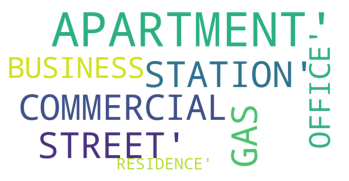

In [6]:
text = df['location_description'].values 

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

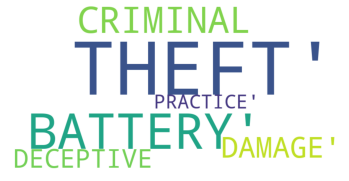

In [7]:
text = df['primary_type'].values 

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Some more data cleaning

In [8]:
# Merging certain similar features
df = dfOriginal.drop(columns=['case_number', 'iucr', 'beat', 'fbi_code', 'updated_on']) #Cleaning by dropping unneeded columns
df.loc[df["primary_type"] == "MOTOR VEHICLE THEFT", "primary_type"] = "THEFT"
df.loc[df["primary_type"] == "CRIMINAL SEXUAL ASSAULT", "primary_type"] = "SEX OFFENSE"
df.loc[df["primary_type"] == "BATTERY", "primary_type"] = "ASSAULT"
df.loc[df["primary_type"] == "CRIMINAL TRESPASS", "primary_type"] = "BURGLARY"
df.loc[df["primary_type"] == "INTERFERENCE WITH PUBLIC OFFICER", "primary_type"] = "PUBLIC PEACE VIOLATION"
df.loc[df["primary_type"] == "OBSCENITY", "primary_type"] = "PUBLIC PEACE VIOLATION"
df.loc[df["primary_type"] == "PUBLIC INDECENCY", "primary_type"] = "SEX OFFENSE"
df.loc[df["primary_type"] == "CONCEALED CARRY LICENSE VIOLATION", "primary_type"] = "WEAPONS VIOLATION"
df.loc[df["primary_type"] == "OTHER NARCOTIC VIOLATION", "primary_type"] = "NARCOTICS"

df.isna().sum().sum() #Drop rows with any missing values, very small amount of data


7911

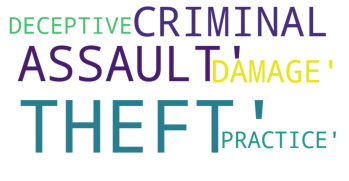

In [9]:
text = df['primary_type'].values 

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Data Visualization**

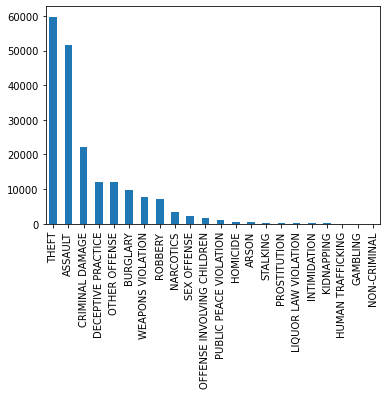

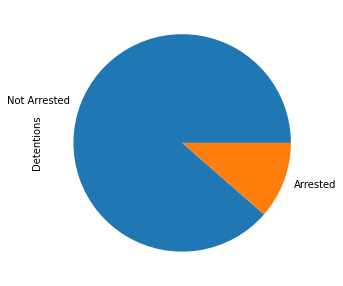

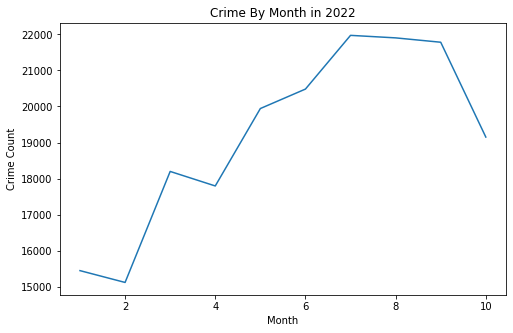

In [10]:
df['primary_type'].value_counts().plot(kind='bar')
plt.show()


arrest_df = df['arrest'].value_counts()
arrest_count = (arrest_df / df['arrest'].sum())
arrest_count.rename("Detentions",inplace=True)
arrest_count.rename({True: 'Arrested', False: 'Not Arrested'},inplace=True)
arrest_count.plot.pie(y=1, figsize=(5, 5))
plt.show()

crimeDate = df.copy(deep=True)
crimeDate.date = pd.to_datetime(crimeDate.date, format = '%Y-%m-%dT%H:%M:%S.000')
crimeDate.index = pd.DatetimeIndex(crimeDate.date)

plt.figure(figsize = (8,5))
crimeDate.groupby([crimeDate.index.month]).size().plot.line()

plt.title('Crime By Month in 2022')
plt.ylabel('Crime Count')
plt.xlabel('Month')
plt.show()

3 visualizations are listed above. Contrary to popular opinion and our hypothesis, homicide was nowhere near the top number of crimes committed in Chicago. Theft and assault accounted for a majority. 

In addition, out of most reported crimes, only about 1/8 of them resulted in arrests. We had hypothesized this, as many crimes go unsolved in Chicago.

Lastly, the final graph shows that crime rises significantly during the warmer spring and summer months, before falling in the winter and fall. This lines up with our hypothesis, as harsher weather depresses all sorts of activity. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report

dfGauss = dfOriginal.copy(deep=True)
dfGauss.date = pd.to_datetime(dfGauss.date)
dfGauss['day_of_week'] = dfGauss.date.dt.day_name()
dfGauss['month'] = dfGauss.date.dt.month_name()
dfGauss['time'] = dfGauss.date.dt.hour


dfGauss.year = pd.Categorical(dfGauss.year)
dfGauss.time = pd.Categorical(dfGauss.time)
dfGauss.domestic = pd.Categorical(dfGauss.domestic)
dfGauss.arrest = pd.Categorical(dfGauss.arrest)
dfGauss.district = pd.Categorical(dfGauss.district)
dfGauss.ward = pd.Categorical(dfGauss.ward)
dfGauss.community_area = pd.Categorical(dfGauss.community_area)
dfGauss.beat = pd.Categorical(dfGauss.beat)
dfPredict = dfGauss.drop(['location','date','block','iucr','primary_type','description','location_description','fbi_code','updated_on','x_coordinate','y_coordinate'],axis=1)
print(dfPredict.head())
dfPredict = pd.get_dummies(dfPredict,drop_first=True)
#df = pd.get_dummies(df,drop_first=True)


#Train test split with a test set size of 30% of entire data
#X_train, X_test, y_train, y_test = train_test_split(df,dfOriginal, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(dfPredict.drop(['arrest_1'],axis=1),dfPredict['arrest_1'], test_size=0.3, random_state=42)
#Standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

#Gaussain Naive Bayes
classifier = GaussianNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()


print('Accuracy = ',metrics.accuracy_score(y_test, y_pred))
print('Error = ',1 - metrics.accuracy_score(y_test, y_pred))
print('Precision = ',metrics.precision_score(y_test, y_pred))
print('Recall = ',metrics.recall_score(y_test, y_pred))
print('F-1 Score = ',metrics.f1_score(y_test, y_pred))
#print('Classification Report\n',metrics.classification_report(y_test, y_pred))

  district      latitude community_area ward case_number  year domestic  \
0      024  42.021675231              1   49    JF452232  2022     True   
1      012  41.902923197             24   26    JF452224  2022    False   
2      001  41.887872453             32   42    JF452230  2022    False   
3      016  41.960718285             76   41    JF452223  2022    False   
4      020  41.974607329              3   47    JF453715  2022    False   

       longitude  beat arrest        id day_of_week    month time  
0  -87.671894136  2422  False  12875321    Thursday  October   23  
1  -87.697288509  1211  False  12874215    Thursday  October   23  
2  -87.619550708  0114  False  12874108    Thursday  October   23  
3  -87.882620302  1654  False  12874165    Thursday  October   23  
4  -87.660635398  2033  False  12876004    Thursday  October   23  


The only parts we have left is the ML analysis, the Reflection, and the Next Steps in the project report. We will finish the ML analysis by doing some more research on methods as well as sklearn documentation. The other two parts should be quickly completed after that. 

# Reflection

The hardest part of the project was that we did not have memory resources while making the code work and it kept crashing for the big dataset we have used.

Currently the biggest problem we are facing is the above mentioned one where the hardware resources are not sufficient to make the code work and this is making it difficult to see if the code is valid and working well.
